In [1]:
import os
import sys 
from flask import Flask
from flask import request
from flask_api import status
import psycopg2
import json
import copy
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
datosBaseDeDatos = {"usuario":"postgres","password":"carlos98","Host":"127.0.0.1","puerto":"5432","DB":"chatblocks"}

In [2]:
def abrirJson(name,path=os.getcwd()+"/" ):
    with open(path+name,encoding='utf-8') as data_file:  
        diccionario = json.load(data_file)
    return diccionario

In [3]:
def conexionBaseDeDatos(datosConexion):
    try:
        connection = psycopg2.connect(user = datosConexion["usuario"],
                              password = datosConexion["password"],
                              host = datosConexion["Host"],
                              port = datosConexion["puerto"],
                              database = datosConexion["DB"])    
        return connection
    except(Exception, psycopg2.Error) as error:
        print("Error al conectar con base de datos", error)

In [4]:
def consultar(connection,datos=False,consulta=False,tabla=False):
    #print("datos",datos)
    consultaBots = list()
    column_names = []
    data_rows = []
    diccionarioDatos = dict()
    consultas = list()
    cursor = connection.cursor()  
    cosulta =""    
    if datos:
        print("intenatando consulta...")
        if tabla == 'robots':
            consulta = "select * from robots where id_face = '"+datos["id_face"]+"';"
        else:
            consulta = "select * from "+tabla+" where "        
            i=0
            for dato, valorDato in datos.items():
                if i==0:
                    consulta = consulta+dato+"= '"+str(valorDato)+"'"                
                else:             
                    consulta = consulta+" and "+dato+"= '"+str(valorDato)+"'" 
                i=i+1
            #print(dato,":",valorDato)
            consulta= consulta + " ;" 
            #print(consulta)        
            #consulta = "select * from robots where name_robot = '"+datosBot["name_robot"]+"' and id_face = '"+ datosBot["id_face"]+"' and  type_blocki = '"+datosBot["type_blocki"]+"' and access_token= '"+datosBot["access_token"]+"' and id_user = '"+datosBot["id_user"]+"';"
    print("consulta:",consulta)
    cursor.execute(consulta)    
    column_names = [desc[0] for desc in cursor.description]  
    rows = cursor.fetchall()
    for row in rows:
        diccionarioDatos = dict()
        for i in range(len(column_names)):
            diccionarioDatos.update({column_names[i]:row[i]})
        consultaBots.append(diccionarioDatos)
    cursor.close()
    connection.close()  
    
    if len(consultaBots)==1:
        return consultaBots[0]
    elif len(consultaBots)==0:
        print('La consulta no trajo nada')
        return {"error": "true"}
    else:
        return consultaBots

In [5]:
def insert(datos,tabla,connection):
    cursor = connection.cursor()
    values = ""
    datosInsert = ""
    i = 0;
    for dato, valorDato in datos.items():
        if i==0:
            values = values+dato 
            datosInsert = datosInsert+"'"+str(valorDato)+"' "                
        else:
            values = values+","+dato
            datosInsert =datosInsert+",'"+str(valorDato)+"' "
        i=i+1
    insersion  = "insert into "+tabla+" ( "+values+" ) values ("+datosInsert+" );" 
    cursor.execute(insersion)
    connection.commit()
    cursor.close()
    connection.close()
    return datos

In [6]:
def update(datosActualizar,datos,tabla,connection):
    actualizar =" "
    actualizar = "update "+tabla+" set"
    j = 0
    for dato,informacionDato in datosActualizar.items():
        print(dato)
        if j==0:
            actualizar=actualizar+" "+dato+"="+str(informacionDato)
            j=j+1
        else:
             actualizar=actualizar+", "+dato+"="+str(informacionDato)
    
    i=0
    actualizar=actualizar+" where "
    for dato, valorDato in datos.items():
        if i==0:
            actualizar = actualizar+dato+"= '"+str(valorDato)+"'"                
        else:             
            actualizar = actualizar+" and "+dato+"= '"+str(valorDato)+"'" 
        i=i+1
    actualizar= actualizar + " ;"  

In [7]:
app = Flask(__name__)
@app.route('/access_token', methods = ['POST'])
def postAccessToken():
    try:         
        connection = conexionBaseDeDatos(datosBaseDeDatos)        
        datosVariable = request.get_json()   
        tabla = "robots"
        con = consultaBots(connection,datos=datosVariable,tabla=tabla)        
        listaAcessToken=list()
        if type(con)==list:
            for i in range(len(con)):
                print(con[i])
                listaAcessToken.append(con[i]["access_token"])
        else:
            listaAcessToken.append(con["access_token"])         
        print(listaAcessToken)
        return {"access_token":listaAcessToken}
    except:
        return datosVariable,status.HTTP_404_NOT_FOUND


In [8]:
@app.route('/insert/<tabla>',methods=['POST'])
def funcionalidad(tabla):
    try:
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        datos = request.get_json()
        print("Datos recibidos:")
        print(datos)
        insert(datos,str(tabla),connection)
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        consulta = consultar(connection,datos=datos,tabla=str(tabla))
        print("Datos enviados:")
        print (consulta)
        return consulta
    except (Exception, psycopg2.Error) as error :
        print("error",error)
        return tabla,status.HTTP_404_NOT_FOUND

In [9]:
@app.route('/select/<tabla>',methods=['GET'])
def select(tabla):
    try:
        connection = conexionBaseDeDatos(datosBaseDeDatos)
        datos = request.get_json()
        print("Datos recibidos:")
        print(datos)
        
        consulta = consultar(connection,datos=datos,tabla=str(tabla))
        print("Datos enviados:")
        print (consulta)
        return consulta
    except (Exception, psycopg2.Error) as error :
        print("error",error)
        return tabla,status.HTTP_404_NOT_FOUND

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:8181/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Mar/2021 22:37:37] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 397, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '397'}
intenatando consulta...
consulta: select * from 
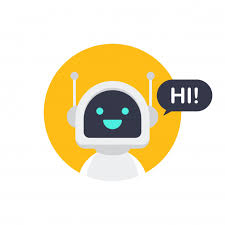

127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 397, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '397' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1153, 'id_robot': 397, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1155, 'id_robot': 397, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 397}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '397' ;
Datos enviados:
{'id_var': 921, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 397, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_qa', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 397, 'id_var': 921, 'blocktype': 'quickReply'}
int

127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= 'var_slide' and id_robot= '397' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_block': 167, 'id_robot': 397, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 167}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '167' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 167, 'id_elements': 406}
Datos
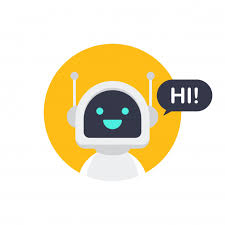
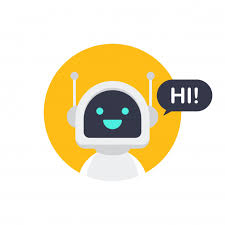
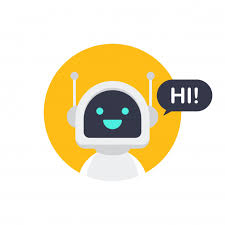

127.0.0.1 - - [17/Mar/2021 22:37:37] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:37:38] "POST /insert/bloqueslide HTTP/1.1" 404 -


Datos recibidos:
{'id_elemento': '406', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '406' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '406', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 625, 'opc_nextid': 'https://www.reddit.com/'}
Datos recibidos:
{'default_id': 'prueba_qa', 'namestate': 'prueba_slide', 'typingtime': 3, 'nombreVariable': 'var_slideMenu', 'tipoVariable': 'Variable', 'tipoDato': 'Cadena', 'id_var': 'var_slide', 'id_robot': 397, 'blocktype': 'slide'}
error no existe la columna «nombrevariable» en la relación «bloqueslide»
LINE 1: ...nto bloqueslide ( default_id,namestate,typingtime,nombreVari...
                                   

127.0.0.1 - - [17/Mar/2021 22:43:55] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1157, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:55] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:56] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_qa' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '398' and id_var= '922' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_qa', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '922', 'id_block': 406, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_robot': 398}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa
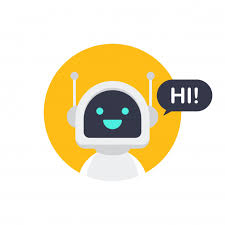
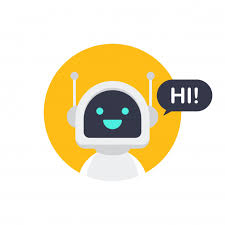
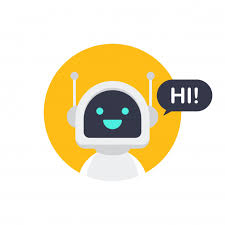

127.0.0.1 - - [17/Mar/2021 22:43:56] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:43:56] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'id_elemento': '407', 'titlebutton': 'Boton 1', 'typebutton': 'url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '407' and titlebutton= 'Boton 1' and typebutton= 'url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '407', 'titlebutton': 'Boton 1', 'typebutton': 'url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 626, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '407', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '407' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_ele

127.0.0.1 - - [17/Mar/2021 22:44:06] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
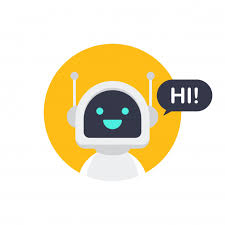

127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/bloqueinformativo HTTP/1.1" 200 -



{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1159, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 

127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1161, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 398}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 923, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_qa', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 398, 'id_var': 923, 'blocktype': 'quickReply'}
int

127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:06] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:07] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= 'var_slide' and id_robot= '398' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_block': 169, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 169}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '169' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 169, 'id_elements': 408}
Datos
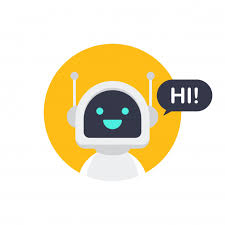
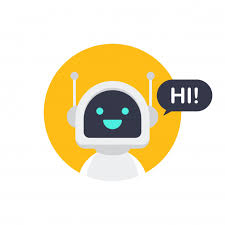
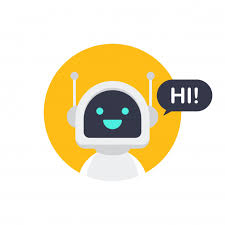

127.0.0.1 - - [17/Mar/2021 22:44:07] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '408' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '408', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 629, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 22:44:34] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:34] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:34] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
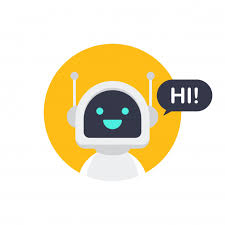

127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1162, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/bloquequickreply HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1164, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 398}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 924, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_

127.0.0.1 - - [17/Mar/2021 22:44:34] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:35] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:44:35] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= 'var_slide' and id_robot= '398' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_block': 170, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 170}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '170' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 170, 'id_elements': 409}
Datos
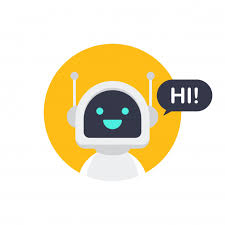
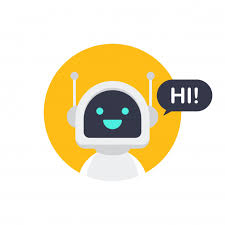
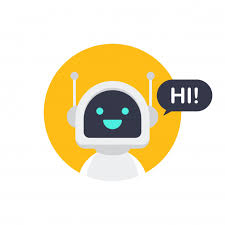

127.0.0.1 - - [17/Mar/2021 22:44:35] "POST /insert/botones HTTP/1.1" 200 -


Datos recibidos:
{'id_elemento': '409', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '409' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '409', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 631, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 22:49:01] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:01] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:01] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
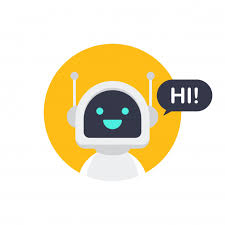

127.0.0.1 - - [17/Mar/2021 22:49:01] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:01] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:01] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1165, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namesta

127.0.0.1 - - [17/Mar/2021 22:49:01] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:01] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:02] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 925, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 398, 'id_var': 925, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '398' and id_var= '925' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre
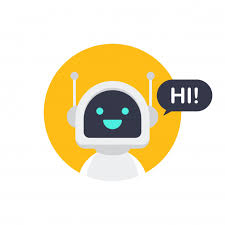

127.0.0.1 - - [17/Mar/2021 22:49:02] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:02] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:49:02] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '171' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 171, 'id_elements': 410}
Datos recibidos:
{'id_elemento': '410', 'titlebutton': 'Boton 1', 'typebutton': 'url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '410' and titlebutton= 'Boton 1' and typebutton= 'url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '410', 'titlebutton': 'Boton 1', 'typebutton': 'url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 632, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '410', 'titlebutto
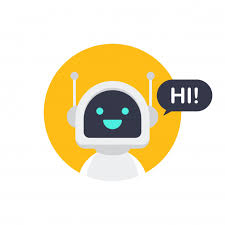
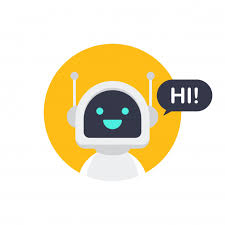

127.0.0.1 - - [17/Mar/2021 22:59:51] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:51] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:51] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
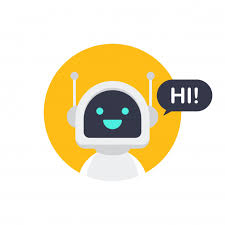

127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1168, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1170, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 398}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 926, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 398, 'id_var': 926, 'blocktype': 'quickReply'}


127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_robot': 398}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= 'var_slide' and id_robot= '398' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': 'var_slide', 'id_block': 172, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 172}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '172' ;
Datos enviados:
{'
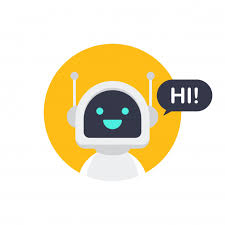
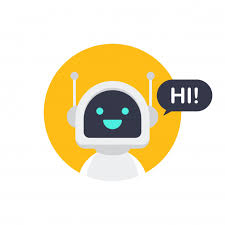
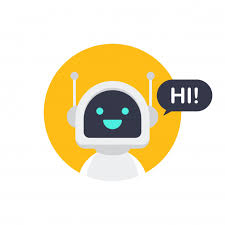

127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 22:59:52] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'id_elemento': '411', 'titlebutton': 'Boton 1', 'typebutton': 'url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 634, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '411', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '411' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '411', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 635, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 23:00:27] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
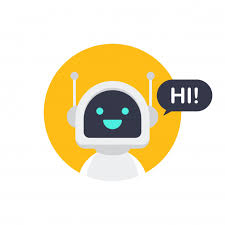

127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1171, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namesta

127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:27] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 927, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 398, 'id_var': 927, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '398' and id_var= '927' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [17/Mar/2021 23:00:28] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:28] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:00:28] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '928' and id_robot= '398' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '928', 'id_block': 173, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 173}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '173' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 173, 'id_elements': 412}
Datos recibidos:

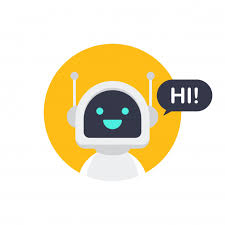
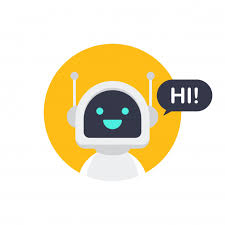
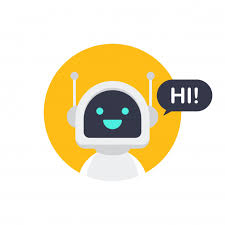

127.0.0.1 - - [17/Mar/2021 23:00:28] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '412' and titlebutton= 'Boton 2' and typebutton= 'url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '412', 'titlebutton': 'Boton 2', 'typebutton': 'url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 637, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 23:08:35] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:35] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:35] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 398, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '398'}
intenatando consulta...
consulta: select * from 
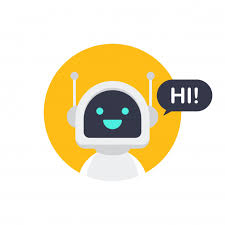

127.0.0.1 - - [17/Mar/2021 23:08:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:35] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '398' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1174, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 398, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namesta

127.0.0.1 - - [17/Mar/2021 23:08:35] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '398' ;
Datos enviados:
{'id_var': 929, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 398, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 398, 'id_var': 929, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '398' and id_var= '929' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '930' and id_robot= '398' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '930', 'id_block': 174, 'id_robot': 398, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 174}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '174' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 174, 'id_elements': 413}
Datos recibidos:

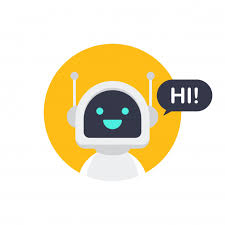
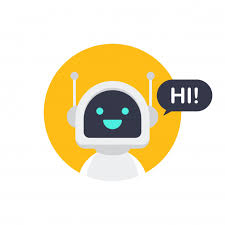
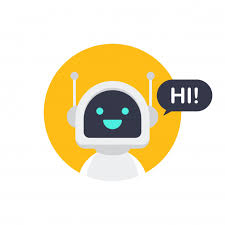

127.0.0.1 - - [17/Mar/2021 23:08:36] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '413' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '413', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 639, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 23:15:45] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 399, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '399' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1178, 'id_robot': 399, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 399, 'blockty

127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '399' ;
Datos enviados:
{'id_var': 931, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 399, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 399, 'id_var': 931, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '399' and id_var= '931' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:45] "POST /insert/elementos HTTP/1.1" 200 -


Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 932, 'id_robot': 399}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '932' and id_robot= '399' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '932', 'id_block': 175, 'id_robot': 399, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 175}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '175' ;
Datos enviados:
{'blocktype': 'slide',
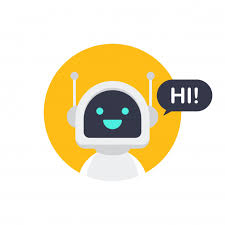
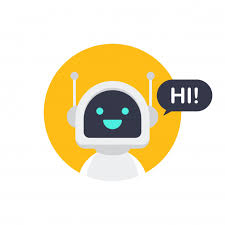
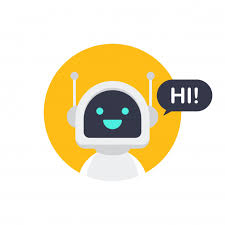

127.0.0.1 - - [17/Mar/2021 23:15:46] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:15:46] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '414' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '414', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 640, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '414', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '414' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '414', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 641, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [17/Mar/2021 23:26:20] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:20] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:20] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
Datos enviados:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 399, 'id_user': 'charlygoldcruz@gmail.com'}
Datos recibidos:
{'id_robot': '399'}
intenatando consulta...
consult
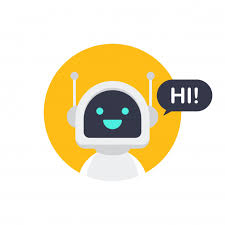

127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 399, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '399' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1180, 'id_robot': 399, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1182, 'id_robot': 399, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 399}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '399' ;
Datos enviados:
{'id_var': 933, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 399, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 399, 'id_var': 933, 'blocktype': 'quickReply'}


127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 399}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '399' ;
Datos enviados:
{'id_var': 934, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 399, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 934, 'id_robot': 399}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '934' and id_robot= '399' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '934', 'id_block': 176, 'id_robot': 399, 'opc_nextid': None, 'pos_y': None, 
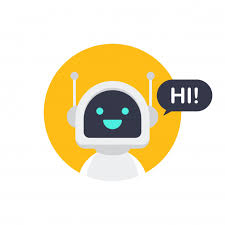

127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:26:21] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '176' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 176, 'id_elements': 415}
Datos recibidos:
{'id_elemento': '415', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '415' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '415', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 642, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '415',
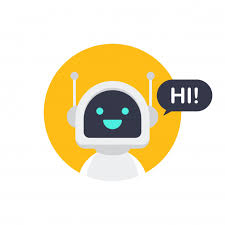
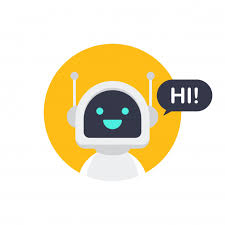

127.0.0.1 - - [17/Mar/2021 23:28:41] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:41] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:41] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '111445520541316';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'charlybot', 'id_face': '111445520541316', 'block_ini': 'prueba_inicio', 'type_blocki': 'informativo', 'access_token': 'EAALZCCZBzPwfkBAAo7njAlW7s4DTj1ZCs5v1ung1MhEyMlJXOOtiG8r7JcBgXVPhZBHkJONyTB6jKG470UyqGPWn4aDPnisgtT2ZCZAwQIjQgZAZBufZBJXmHz6mPKSgdmP6ikDA87vocZBay2dfQdz1OYezmYbxwfILXUvXtjUMZAniQZDZD', 'id_user': 'charlygoldcruz@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...


127.0.0.1 - - [17/Mar/2021 23:28:41] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:41] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 400, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '400' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1184, 'id_robot': 400, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 400, 'blockty

127.0.0.1 - - [17/Mar/2021 23:28:41] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'id_var': 935, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 400, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 400, 'id_var': 935, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '400' and id_var= '935' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '935', 'id_block':

127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '400' ;
Datos enviados:
{'id_var': 936, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 400, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 936, 'id_robot': 400}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '936' and id_robot= '400' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '936', 'id_block': 177, 'id_robot': 400, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': '', 'subtitle
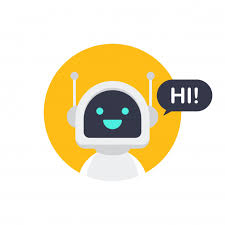
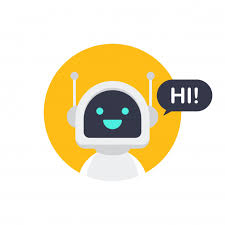
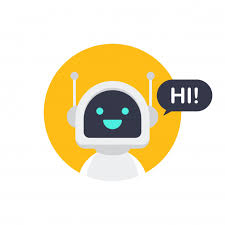

127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:28:42] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '416' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '416', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 644, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '416', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'opc_nextid': 'https://www.reddit.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '416' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '416', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 645, 'opc_nextid': 'https://www.redd

127.0.0.1 - - [17/Mar/2021 23:34:38] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
La consulta no trajo nada
Datos enviados:
{'error': 'true'}
Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select 

127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_qa' and contenido= 'Vamos a ver si no truena' and contenttype= 'text' and typingtime= '7' and id_robot= '401' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '7', 'id_block': 1187, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'Salida', 'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 401, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'Salida' and namestate= 'prueba_dos' and contenido= 'Puedo hacer muchas cosas, entre ellas despedirme. Adios' and 

127.0.0.1 - - [17/Mar/2021 23:34:38] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:39] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:39] "POST /insert/bloqueslide HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '401' and id_var= '937' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'blocktype': 'quickReply', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '937', 'id_block': 416, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 401}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos envia
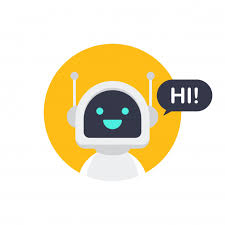

127.0.0.1 - - [17/Mar/2021 23:34:39] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:39] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:34:39] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= '' and subtitle= 'Esta es una prueba de carrusel.' and blocktype= 'slide' and id_block= '178' ;
Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': '', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 178, 'id_elements': 417}
Datos recibidos:
{'id_elemento': '417', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'opc_nextid': 'https://www.youtube.com/'}
intenatando consulta...
consulta: select * from botones where id_elemento= '417' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'https://www.youtube.com/' and opc_nextid= 'https://www.youtube.com/' ;
Datos enviados:
{'id_elemento': '417', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'https://www.youtube.com/', 'id_boton': 646, 'opc_nextid': 'https://www.youtube.com/'}
Datos recibidos:
{'id_elemento': '417',
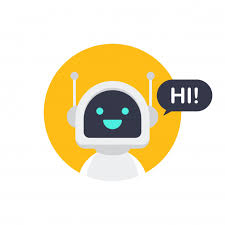
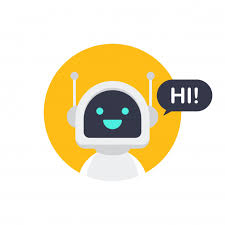

127.0.0.1 - - [17/Mar/2021 23:39:01] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:01] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 401, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '401'}
intenatando consulta...
consulta: select * from 
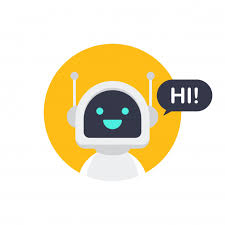

127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 401, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '401' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1189, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': '

127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 939, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 401, 'id_var': 939, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '401' and id_var= '939' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '940' and id_robot= '401' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '940', 'id_block': 179, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 179}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blockt

127.0.0.1 - - [17/Mar/2021 23:39:02] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '418' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '418', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 649, 'opc_nextid': 'https://www.reddit.com/'}


127.0.0.1 - - [17/Mar/2021 23:48:50] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:50] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:50] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 401, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '401'}
intenatando consulta...
consulta: select * from 

127.0.0.1 - - [17/Mar/2021 23:48:50] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 401, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '401' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1192, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1194, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 401}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 941, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 401, 'id_var': 941, 'blocktype': 'quickReply'}


127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/elementos HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 942, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 942, 'id_robot': 401}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '942' and id_robot= '401' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '942', 'id_block': 180, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.

127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:48:51] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '419' and titlebutton= 'Boton 1' and typebutton= 'web_url' and contentbutton= 'prueba_qa' and opc_nextid= 'prueba_qa' ;
Datos enviados:
{'id_elemento': '419', 'titlebutton': 'Boton 1', 'typebutton': 'web_url', 'contentbutton': 'prueba_qa', 'id_boton': 650, 'opc_nextid': 'prueba_qa'}
Datos recibidos:
{'id_elemento': '419', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'prueba_inicio', 'opc_nextid': 'prueba_inicio'}
intenatando consulta...
consulta: select * from botones where id_elemento= '419' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'prueba_inicio' and opc_nextid= 'prueba_inicio' ;
Datos enviados:
{'id_elemento': '419', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'prueba_inicio', 'id_boton': 651, 'opc_nextid': 'prueba_inicio'}


127.0.0.1 - - [17/Mar/2021 23:49:26] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:26] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:26] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 401, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '401'}
intenatando consulta...
consulta: select * from 

127.0.0.1 - - [17/Mar/2021 23:49:26] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:26] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'contenttype': 'text', 'typingtime': 3, 'id_robot': 401, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '401' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1195, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa

127.0.0.1 - - [17/Mar/2021 23:49:26] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:26] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/bloquequickreply HTTP/1.1" 200 -


Datos enviados:
{'namestate': 'prueba_dos', 'contenido': 'Puedo hacer muchas cosas, entre ellas despedirme. Adios', 'next_id': 'Salida', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1197, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'name_var': 'var_case', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 401}
intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 943, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 401, 'id_var': 943, 'blocktype': 'quickReply'}


127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/bloqueslide HTTP/1.1" 200 -


Datos recibidos:
{'name_var': 'var_slideMenu', 'opc_type': 'Variable', 'var': 0, 'opc_data': 'Numerico', 'id_robot': 401}
intenatando consulta...
consulta: select * from variables where name_var= 'var_slideMenu' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 944, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_slideMenu'}
Datos recibidos:
{'namestate': 'prueba_slide', 'blocktype': 'slide', 'typingtime': 3, 'default_id': 'prueba_qa', 'id_var': 944, 'id_robot': 401}
intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '944' and id_robot= '401' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '944', 'id_block': 181, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 

127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/botones HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:49:27] "POST /insert/botones HTTP/1.1" 200 -


Datos enviados:
{'blocktype': 'slide', 'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'id_block': 181, 'id_elements': 420}
Datos recibidos:
{'id_elemento': '420', 'titlebutton': 'Boton 1', 'typebutton': 'postback', 'contentbutton': 'prueba_qa', 'opc_nextid': 'prueba_qa'}
intenatando consulta...
consulta: select * from botones where id_elemento= '420' and titlebutton= 'Boton 1' and typebutton= 'postback' and contentbutton= 'prueba_qa' and opc_nextid= 'prueba_qa' ;
Datos enviados:
{'id_elemento': '420', 'titlebutton': 'Boton 1', 'typebutton': 'postback', 'contentbutton': 'prueba_qa', 'id_boton': 652, 'opc_nextid': 'prueba_qa'}
Datos recibidos:
{'id_elemento': '420', 'titlebutton': 'Boton 2', 'typebutton': 'postback', 'contentbutton': 'prueba_inicio', 'opc_nextid': 'prueba_inicio'}
intenatando consulta...
consulta: select * from botones wh

127.0.0.1 - - [17/Mar/2021 23:54:36] "GET /select/robots HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:36] "GET /select/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:36] "GET /select/elementos HTTP/1.1" 200 -


Datos recibidos:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'id_user': 'oliverbp88@gmail.com', 'api_nlp': 'http://localhost:8282/'}
intenatando consulta...
consulta: select * from robots where id_face = '2153123008120093';
Datos enviados:
{'name_robot': 'oliverBot', 'id_face': '2153123008120093', 'block_ini': 'prueba_inicio', 'type_blocki': 'quickreply', 'access_token': 'EAAHNkscg2TcBAMvebksfOxuFBpMeR5sUhzHTKtqdi6NkqQKZAdkeaGVJ9Yc5bNbvL3JLzCgB7EEqsVUTZADhidVcC3zJV1UZB4Uz0Hm3fZB9IETnWb4I8MoK8nxpenC1lYwnjwnRwMHVZA1FKw8d3A45t9xCxmPKnm6kIr5ZCA8wZDZD', 'api_nlp': 'http://localhost:8282/', 'id_robot': 401, 'id_user': 'oliverbp88@gmail.com'}
Datos recibidos:
{'id_robot': '401'}
intenatando consulta...
consulta: select * from 

127.0.0.1 - - [17/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:36] "POST /insert/bloqueinformativo HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namestate= 'prueba_inicio' and contenido= 'Hola, soy un chatbot y esto es un mensaje de prueba y adios' and contenttype= 'text' and typingtime= '3' and id_robot= '401' and blocktype= 'informativo' ;
Datos enviados:
{'namestate': 'prueba_inicio', 'contenido': 'Hola, soy un chatbot y esto es un mensaje de prueba y adios', 'next_id': 'pruebaCorreo_01inicial_inicial', 'blocktype': 'informativo', 'contenttype': 'text', 'typingtime': '3', 'id_block': 1198, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'tag_active': None}
Datos recibidos:
{'next_id': 'pruebaCorreo_01inicial_inicial', 'namestate': 'prueba_qa', 'contenido': 'Vamos a ver si no truena', 'contenttype': 'text', 'typingtime': 7, 'id_robot': 401, 'blocktype': 'informativo'}
intenatando consulta...
consulta: select * from bloqueinformativo where next_id= 'pruebaCorreo_01inicial_inicial' and namesta

127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/variables HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/bloquequickreply HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/variables HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from variables where name_var= 'var_case' and opc_type= 'Variable' and var= '0' and opc_data= 'Numerico' and id_robot= '401' ;
Datos enviados:
{'id_var': 945, 'opc_type': 'Variable', 'opc_data': 'Numerico', 'var': '0', 'id_robot': 401, 'name_var': 'var_case'}
Datos recibidos:
{'contenido': '¿Cuál es tu correo?', 'opciones': 'email,otro', 'next_id': 'prueba_dos,prueba_slide', 'default_id': 'prueba_qa', 'namestate': 'pruebaCorreo_01inicial_inicial', 'typingtime': 3, 'id_robot': 401, 'id_var': 945, 'blocktype': 'quickReply'}
intenatando consulta...
consulta: select * from bloquequickreply where contenido= '¿Cuál es tu correo?' and opciones= 'email,otro' and next_id= 'prueba_dos,prueba_slide' and default_id= 'prueba_qa' and namestate= 'pruebaCorreo_01inicial_inicial' and typingtime= '3' and id_robot= '401' and id_var= '945' and blocktype= 'quickReply' ;
Datos enviados:
{'namestate': 'pruebaCorreo_01inicial_inicial', 'contenido': '¿Cuál es tu corre

127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/bloqueslide HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/elementos HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from bloqueslide where namestate= 'prueba_slide' and blocktype= 'slide' and typingtime= '3' and default_id= 'prueba_qa' and id_var= '946' and id_robot= '401' ;
Datos enviados:
{'namestate': 'prueba_slide', 'next_id': None, 'blocktype': 'slide', 'typingtime': '3', 'default_id': 'prueba_qa', 'id_var': '946', 'id_block': 182, 'id_robot': 401, 'opc_nextid': None, 'pos_y': None, 'pos_x': None, 'opc_elm': None, 'tag_active': None}
Datos recibidos:
{'title': 'Prueba titulo', 'image_url': 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg', 'subtitle': 'Esta es una prueba de carrusel.', 'blocktype': 'slide', 'id_block': 182}
intenatando consulta...
consulta: select * from elementos where title= 'Prueba titulo' and image_url= 'https://st2.depositphotos.com/3008028/5540/i/600/depositphotos_55407975-stock-photo-royal-blue-background.jpg' and subtitle= 'Esta es una prueba de carrusel.' and blockt

127.0.0.1 - - [17/Mar/2021 23:54:37] "POST /insert/botones HTTP/1.1" 200 -


intenatando consulta...
consulta: select * from botones where id_elemento= '421' and titlebutton= 'Boton 2' and typebutton= 'web_url' and contentbutton= 'https://www.reddit.com/' and opc_nextid= 'https://www.reddit.com/' ;
Datos enviados:
{'id_elemento': '421', 'titlebutton': 'Boton 2', 'typebutton': 'web_url', 'contentbutton': 'https://www.reddit.com/', 'id_boton': 655, 'opc_nextid': 'https://www.reddit.com/'}


In [ ]:
if __name__ == "__main__":    
    app.run(host='localhost',port='8181')